# Gradience Demo

This notebook demonstrates how to use Gradience to optimize an LC-MS gradient for maximizing product separation.

## Step 1: Setup

Import required modules, define the target reaction, and configure the LC-MS method.

In [ ]:
import asyncio
import numpy as np
import matplotlib.pyplot as plt
from pipeline import run_pipeline
from pipeline import OPTIMIZER_CONFIG
from optimizer.gradient_params import params_to_gradient

# define reaction
reactants = ["CC(=O)OC(C)=O"]
solvent = "CCO"

print(f"Reactants: {reactants}")
print(f"Solvent: {solvent}")

# custom lcms configuration
lcms_config = {
    'solvents': {
        'A': [
            {'O': 94.9, 'CC#N': 5.0},
            {'C(=O)O': 0.1}
        ],
        'B': [
            {'CC#N': 99.9},
            {'C(=O)O': 0.1}
        ]
    },
    'column': ('RP', 2.1, 100, 1.7),
    'flow_rate': 0.4,
    'temp': 45.0,
    'method_length': 12.0
}

print("Custom LC-MS Configuration:")
print(f"  Phase A: 94.9% H2O, 5% ACN, 0.1M formic acid")
print(f"  Phase B: 99.9% ACN, 0.1M formic acid")
print(f"  Column: {lcms_config['column'][0]} {lcms_config['column'][2]}x{lcms_config['column'][1]}mm, {lcms_config['column'][3]}μm")
print(f"  Flow Rate: {lcms_config['flow_rate']} mL/min")
print(f"  Temperature: {lcms_config['temp']} °C")
print(f"  Method Length: {lcms_config['method_length']} min")

Reactants: ['CC(=O)OC(C)=O']
Solvent: CCO
Custom LC-MS Configuration:
  Phase A: 94.9% H2O, 5% ACN, 0.1M formic acid
  Phase B: 99.9% ACN, 0.1M formic acid
  Column: RP 100x2.1mm, 1.7μm
  Flow Rate: 0.4 mL/min
  Temperature: 45.0 °C
  Method Length: 12.0 min


## Step 2: Configure & Run Optimization

Set up parameters for TuRBO optimization, then run the process.

This Will:
1. Query ASKCOS for product predictions
2. Predict retention times for each compound
3. Optimize gradient to maximize product separation
4. Save results to an OptGradient `.json` file


In [2]:
# customize optimizer for faster demo
optimizer_config = OPTIMIZER_CONFIG.copy()
optimizer_config['max_evals'] = 100
optimizer_config['n_init'] = 36 

print("Optimizer Configuration:")
print(f"  Dimensions: {optimizer_config['dim']}D (10 %B + 8 time spacings)")
print(f"  Initial Samples: {optimizer_config['n_init']}")
print(f"  Max Evaluations: {optimizer_config['max_evals']}")
print(f"  Trust Region Init: {optimizer_config['trust_region_init']}")
print(f"  Trust Region Min: {optimizer_config['trust_region_min']}")

await run_pipeline(
    reactant_smiles=reactants,
    solvent_smiles=solvent,
    lcms_config=lcms_config,
    optimizer_config=optimizer_config,
    output_file="demo.json"
)

Optimizer Configuration:
  Dimensions: 18D (10 %B + 8 time spacings)
  Initial Samples: 36
  Max Evaluations: 100
  Trust Region Init: 0.8
  Trust Region Min: 0.1
LC-MS gradient optimization pipeline
Combined reactants: CC(=O)OC(C)=O
Navigating to ASKCOS forward page...
Navigating to Product Prediction tab...
Clicked Product Prediction tab
Navigating to Reactants tab
Entered Reactants
Navigating to Solvents tab
Entered Solvents
Navigating to Results button...
Clicked Get Results button
Navigating to Export button...
Clicked Export button
found 34 compounds
initial sampling: 36 points
  eval 10/100: y = 0.0181
  eval 20/100: y = 0.0303
  eval 30/100: y = 0.0186
  eval 36/100: y = 0.0227
  eval 40/100: y = 0.0238 (best = 0.0498)
  trust region shrunk to 0.400
  trust region shrunk to 0.200
  eval 50/100: y = 0.0561 (best = 0.0561)
  trust region shrunk to 0.100
  trust region restart at eval 56
  eval 60/100: y = 0.0298 (best = 0.0713)
  trust region shrunk to 0.400
  trust region shrunk

## Step 3: Load & Visualize Results

Visualize the output gradeint and plot the gradient profile.

Found 34 Compounds
Separation Score: 0.0814

Optimized Gradient:
    0.00 min:  19.3% B
    0.89 min:  13.1% B
    1.79 min:  43.0% B
    3.77 min:  71.2% B
    4.04 min:  84.9% B
    4.67 min:  11.4% B
    6.38 min:  57.7% B
    7.20 min:   1.5% B
    8.75 min:  73.0% B
   12.00 min:  85.5% B


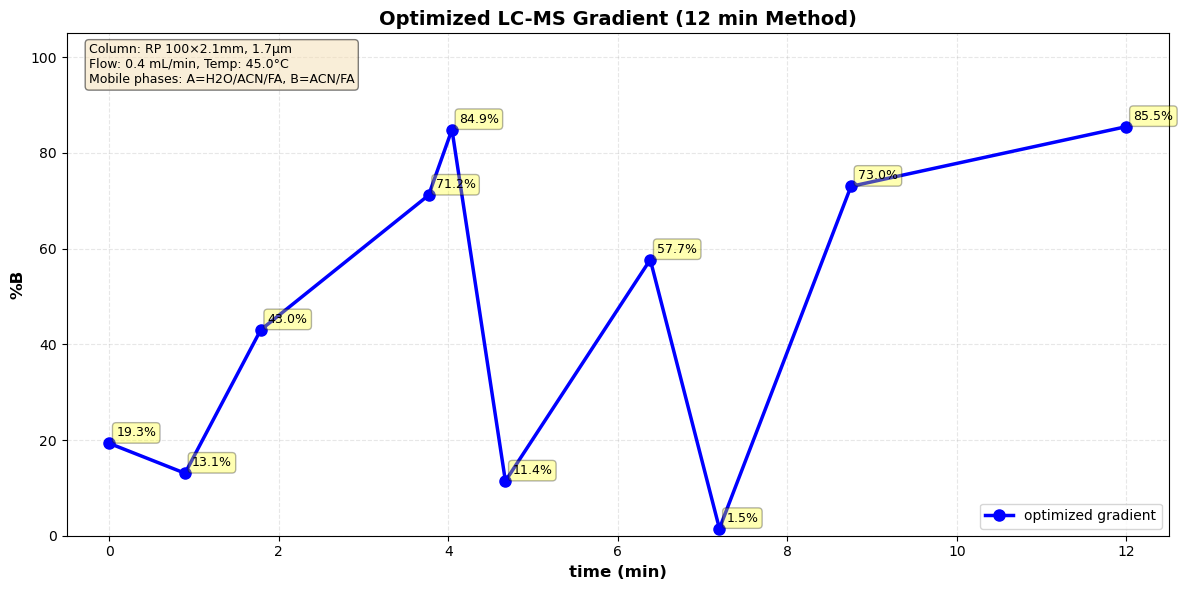


Gradient Profile: 10 Points Over 12.0 Minutes


In [ ]:
import json
from pipeline import plot_gradient

# load results
with open("results/OptGradient_demo.json", "r") as f:
    results = json.load(f)

print(f"Found {len(results['predicted_products'])} Compounds")
print(f"Separation Score: {results['separation_score']:.4f}")
print(f"\nOptimized Gradient:")
for time, percent_b in results['optimized_gradient']:
    print(f"  {time:6.2f} min: {percent_b:5.1f}% B")

# plot the optimized gradient using visualize_gradient module
plot_gradient(
    params=np.array(results['gradient_params']),
    total_time=lcms_config['method_length'],
    title=f"Optimized LC-MS Gradient ({lcms_config['method_length']:.0f} min Method)",
    lcms_config=lcms_config
)